# Systematic Error Analysis in Sound-based Digital Communication System

<font color='blue'>**jasmyn**</font>     @stanford.edu

In [1]:
# Importing packages that are already installed
import numpy as np
π = np.pi

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)  # make the graphs wider

from numpy.random import default_rng
rng = default_rng()

from simulated_channel import simulated_channel

import sounddevice as sd
sd.default.channels = 1

from scipy.fft import rfft, irfft, rfftfreq

from viterbi import viterbi_decode

import time

# Part 1: Implementation and Preparation
In this project, I aim to analyze systematic error in 6 unique settings: 
1. Without noise (simulated)
2. Without noise (physical)
3. With noise (clapping)
4. With noise (speaking)
5. With frequency domain filtering 
6. With error correction (convolution encoding and viterbi decoding)

In order to accomplish this, I will first need functions that report the bit error rates for each of the following settings. This will allow me to call these functions many times to calculate the error rate over multiple trials by varying the data rates. In this step I implement functions that report bit error rates for settings 1, 2, 5, and 6 individually, and create one function that combines 3 and 4 by taking in a noisy signal as a parameter. 

In [2]:
# Defining Constants: 
fs = 44100
safe_duration = 13

# Helper Functions: 
def bandpass(spectrum, fs, fmin, fmax):
    filtered = np.zeros(spectrum.size, dtype=complex)
    N = 2 * spectrum.size
    imin = int(fmin * N / fs)
    imax = int(fmax * N / fs)
    filtered[imin:imax] = spectrum[imin:imax]
    return filtered

def conv_encode(message):
    """Encodes the `message` using the convolutional code discussed in lecture.
    `message` should be a 1-D `np.ndarray` of integers, all 1 or 0.
    Returns a 1-D `np.ndarray` of integers, all 1 or 0.
    """
    zeros = [0, 0]  # Pad with two leading/trailing zeros so every bit passes through all 3 positions 
    padded = np.concatenate((zeros, message, zeros))
    encoded = np.zeros(2 * (len(padded) - 2), dtype='uint8') # Initialize np vector 

    # Use convolution encoding to encode the message
    for i in range(2, len(padded)): 
        cur = padded[i] ^ padded[i - 1] ^ padded[i - 2] 
        nxt = padded[i] ^ padded[i - 2] 
        encoded[2 * (i - 2)] = cur 
        nxt = encoded[2 * (i - 2) + 1] = nxt
    return encoded

In [3]:
def simulated_no_noise(rate, fc, print_bool=True):
    # Generate a random signal
    rng = default_rng(seed=2024)
    message = rng.integers(0, 2, 3*rate)
    message = np.insert(message, 0, 1)  # always start the message with a 1 (we'll see why soon)
    T = 1 / rate
    k = len(message)
    t = np.arange(0, k*T, 1/fs)
    envelope = message[np.floor(t / T).astype(int)]
    x = np.sin(2*np.pi*fc*t) * envelope

    # Add silence to the signal
    tmax = k*T
    silence = 0.5  # seconds
    x_silence = np.append(x, np.zeros(int(silence * fs)))
    t = np.arange(0, tmax + silence, 1/fs)

    # Use the simulated channel to avoid adding too much noise 
    y = simulated_channel(x_silence)

    # Decode 
    threshold = 5 // rate
    delay = np.nonzero(np.abs(y) > threshold)[0][0]
    energy = np.zeros(len(message))
    decoded = np.zeros(len(message), dtype = np.int8)

    threshold = np.max(energy) / 2
    for i in range(len(decoded)):
        start = (i * fs) // rate + delay
        end = ((i + 1) * fs) // rate + delay
        energy[i] += np.mean(y[start: end] ** 2)
    threshold_energy = np.max(energy)/2

    decoded = (energy > threshold_energy).astype(int)

    #Print out error message
    error_rate = np.sum(decoded != message) / message.size
    if print_bool:
        print("Data rate:   ", rate)
        print("Error rate:  ", error_rate)
    return error_rate

rate = 500
fc = 3000
error_rate = simulated_no_noise(rate, fc)

Data rate:    500
Error rate:   0.0


In [5]:
def physical_quiet(rate, fc, print_bool=True):
    # Generate a random signal
    rng = default_rng(seed=2024)
    message = rng.integers(0, 2, 3*rate)
    message = np.insert(message, 0, 1)  # always start the message with a 1 (we'll see why soon)
    T = 1 / rate
    k = len(message)
    t = np.arange(0, k*T, 1/fs)
    envelope = message[np.floor(t / T).astype(int)]
    x = np.sin(2*np.pi*fc*t) * envelope

    # Add silence to the signal
    tmax = k*T
    silence = 0.5  # seconds
    x_silence = np.append(x, np.zeros(int(silence * fs)))
    t = np.arange(0, tmax + silence, 1/fs)

    # Use the physical channel (in quiet environment to avoid too much noise)
    y = sd.playrec(x_silence, fs, blocking=True)

    # Decode 
    threshold = 0.05
    delay = np.nonzero(np.abs(y) > threshold)[0][0]
    energy = np.zeros(len(message))
    decoded = np.zeros(len(message), dtype = np.int8)

    threshold = np.max(energy) / 2
    for i in range(len(decoded)):
        start = (i * fs) // rate + delay
        end = ((i + 1) * fs) // rate + delay
        energy[i] += np.mean(y[start: end] ** 2)
    threshold_energy = np.max(energy)/2
    decoded = (energy > threshold_energy).astype(int)

    # Print out error message
    error_rate = np.sum(decoded != message) / message.size
    if print_bool: 
        print("Data rate:   ", rate)
        print("Error rate:  ", error_rate)
    return error_rate

rate = 50
fc = 3000
error_rate = physical_quiet(rate, fc)

Data rate:    50
Error rate:   0.0


In [6]:
# Recording different sounds 
def record_background_noise(duration, message): 
    print("Background Recording starting " + message)
    noise = sd.rec(int(duration * fs), fs, blocking=True)
    sd.wait()
    return noise.flatten()

In [34]:
# Record noise to uniformly add different types of noise to the signal
clapping = record_background_noise(safe_duration, "Start Clapping")
print("Stop Clapping") 
time.sleep(2)
speaking = record_background_noise(safe_duration, "Start Speaking ")
print("Done. ✅")

Background Recording starting Start Clapping
Stop Clapping
Background Recording starting Start Speaking 
Done. ✅


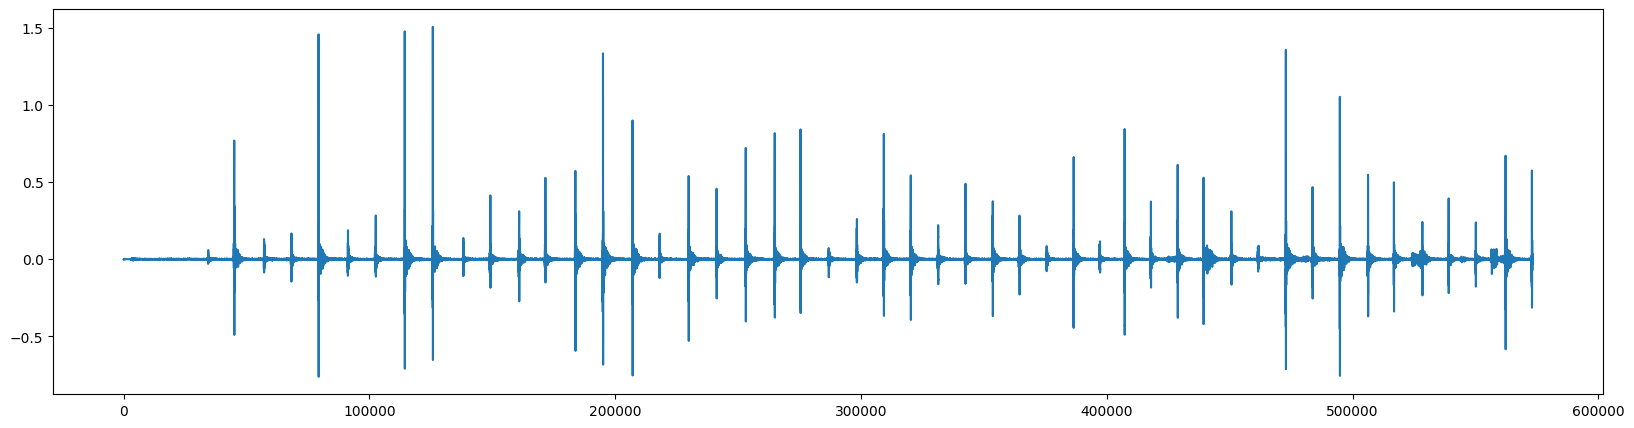

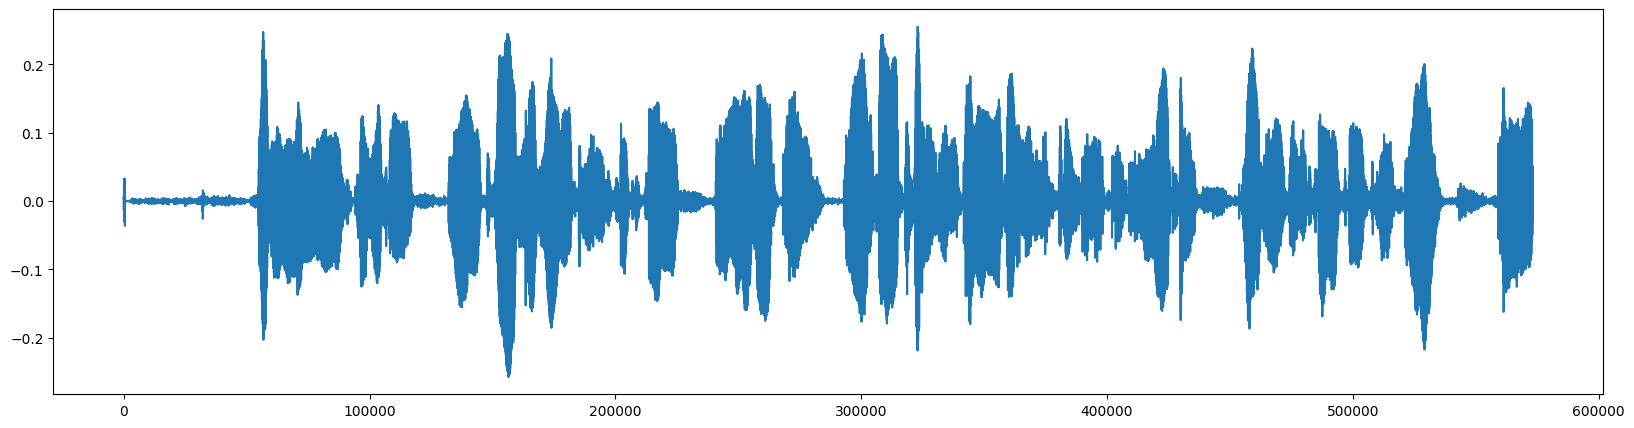

In [35]:
plt.plot(clapping)
plt.show()
plt.plot(speaking)
plt.show()

In [36]:
def crop_noise_length(signal, noise): 
    if len(noise) > len(signal): 
        noise = noise[: len(signal)]
    else:  # The noise is recorded for a safe duration and ideally should never get here
           # but, if it does, repeat the noise for the length of the signal 
        noise = np.tile(noise, int(np.ceil(signal_length / noise_length)))[:signal_length]
    return noise

In [37]:
def physical_noisy(rate, fc, noise, print_bool=True):
    # Generate a random signal
    rng = default_rng(seed=2024)
    message = rng.integers(0, 2, 3*rate)
    message = np.insert(message, 0, 1)  # always start the message with a 1 (we'll see why soon)
    T = 1 / rate
    k = len(message)
    t = np.arange(0, k*T, 1/fs)
    envelope = message[np.floor(t / T).astype(int)]
    x = np.sin(2*np.pi*fc*t) * envelope

    # Add silence to the signal
    tmax = k*T
    silence = 0.5  # seconds
    x_silence = np.append(x, np.zeros(int(silence * fs)))
    t = np.arange(0, tmax + silence, 1/fs)

    # Use the physical channel (in quiet environment to avoid too much noise)
    y = sd.playrec(x_silence, fs, blocking=True).flatten()

    # Add noise to y
    cropped_noise = crop_noise_length(y, noise)
    y += cropped_noise

    # Decode 
    threshold = 0.001
    delay = np.nonzero(np.abs(y) > threshold)[0][0]
    energy = np.zeros(len(message))
    decoded = np.zeros(len(message), dtype = np.int8)

    threshold = np.max(energy) / 2
    for i in range(len(decoded)):
        start = (i * fs) // rate + delay
        end = ((i + 1) * fs) // rate + delay
        energy[i] += np.mean(y[start: end] ** 2)
    threshold_energy = np.max(energy)/2
    decoded = (energy > threshold_energy).astype(int)

    # Print out error message and store error rate for noisy signal
    error_rate = np.sum(decoded != message) / message.size
    if print_bool: 
        print("Error rate:  ", error_rate)
    return error_rate

rate = 50
fc = 3000
filtered_error_rate = physical_noisy(rate, fc, speaking)

Error rate:   0.4503311258278146


In [40]:
def filtered_noisy(rate, fc, noise, print_bool=True):
    # Generate a random signal
    rng = default_rng(seed=2024)
    message = rng.integers(0, 2, 3*rate)
    message = np.insert(message, 0, 1)  # always start the message with a 1 (we'll see why soon)
    T = 1 / rate
    k = len(message)
    t = np.arange(0, k*T, 1/fs)
    envelope = message[np.floor(t / T).astype(int)]
    x = np.sin(2*np.pi*fc*t) * envelope

    # Add silence to the signal
    tmax = k*T
    silence = 0.5  # seconds
    x_silence = np.append(x, np.zeros(int(silence * fs)))
    t = np.arange(0, tmax + silence, 1/fs)

    # Use the physical channel (in quiet environment to avoid too much noise)
    y = sd.playrec(x_silence, fs, blocking=True).flatten()

    # Add noise to y
    cropped_noise = crop_noise_length(y, noise)
    y += cropped_noise

    # Decode 
    threshold = 0.001
    delay = np.nonzero(np.abs(y) > threshold)[0][0]
    energy = np.zeros(len(message))
    decoded = np.zeros(len(message), dtype = np.int8)

    threshold = np.max(energy) / 2
    for i in range(len(decoded)):
        start = (i * fs) // rate + delay
        end = ((i + 1) * fs) // rate + delay
        energy[i] += np.mean(y[start: end] ** 2)
    threshold_energy = np.max(energy)/2
    decoded = (energy > threshold_energy).astype(int)

    # Filter the signal to get the BER of the frequency domain filtering
    y_fft = rfftfreq(y.size, 1/fs)
    y_fft = rfft(y)
    filtered = bandpass(y_fft, fs, fc - 200, fc + 200)
    physical_signal = irfft(filtered)
    threshold = 0.05
    delay = np.nonzero(np.abs(physical_signal) > threshold)[0][0]
    energy = np.zeros(len(message))
    decoded = np.zeros(len(message), dtype = np.int8)
    threshold = np.max(energy) / 2
    for i in range(len(decoded)):
        start = (i * fs) // rate + delay
        end = ((i + 1) * fs) // rate + delay
        energy[i] += np.mean(physical_signal[start: end] ** 2)
    threshold_energy = np.max(energy)/2
    decoded = (energy > threshold_energy).astype(int)

    # Print out error message and save the filtered BER in a variable to return
    filtered_error_rate = np.sum(decoded != message) / message.size
    if print_bool:
        print("Filtered Error rate:       ", filtered_error_rate)
    return filtered_error_rate

rate = 50
fc = 3000
filtered_error_rate = filtered_noisy(rate, fc, clapping)

Filtered Error rate:        0.0


In [39]:
def physical_error_correction(rate, fc, noise, print_bool=True): 
    # Generate a random signal
    rng = default_rng(seed=2024)
    message = rng.integers(0, 2, 3*rate)
    message = np.insert(message, 0, 1)  # always start the message with a 1 (we'll see why soon)

    # Encode the message with convolutional encoding
    conv_encoded = conv_encode(message)
    
    T = 1 / rate
    k = len(conv_encoded)
    t = np.arange(0, k*T, 1/fs)[:-1]
    baseband = conv_encoded[np.floor(t / T).astype(int)]

    # generate the baseband signal
    f_fft = rfftfreq(baseband.size, 1/fs)
    baseband_fft = rfft(baseband)

    # Modulate the signal using OOK
    x = np.sin(2*π*fc*t) * baseband
    silence = 0.5  # seconds
    x_extended = np.append(x, np.zeros(int(silence * fs)))

    # Use sd.playrec to transmit it to your microphone
    y = sd.playrec(x_extended, fs, blocking=True).flatten()
    
    # Add noise to y
    cropped_noise = crop_noise_length(y, noise)
    y += cropped_noise

    # Filter the recieved signal
    y_fft_filtered = bandpass(rfft(y), fs, fc - rate, fc + rate)
    y_filtered = irfft(y_fft_filtered)

    # Demodulate the filtered received signal and report the BER
    start = np.where(y_filtered ** 2 > 0.01)[0][0]
    stop = start + np.arange(0, k*T, 1/fs).size-1
    ytrunc = y_filtered[start:stop]
    
    # Decode
    t = np.arange(0, k*T, 1/fs)[:-1]
    sampling_indices = np.floor(t / T).astype(int)
    energy = np.zeros(k)
    for i, j in enumerate(sampling_indices):
        energy[j] += np.abs(ytrunc[i])
        
    # remove first bit (set to 1 for synchronization)
    threshold = np.max(energy) / 2
    demodulated = (energy > threshold).astype(int)
    
    # Decode using Viterbi decoding and get the BER 
    decoded = viterbi_decode(demodulated)
    corrected_ber = np.sum(decoded != message) / message.size
    if print_bool: 
        print("BER of decoded signal:   ", corrected_ber)
    return corrected_ber

rate = 50
fc = 3000
corrected_error_rate = physical_error_correction(rate, fc, clapping)

BER of decoded signal:    0.0


# Part 2: Experiments and Generating Plots

Now that we have separate functions that will report the bit error rate under different settings, we can begin to plot data rate vs error rate for different values of carrier frequencies (fc) to analyze the effects of modifying the fc and data rate on error rate. The cells below plot the data rate versus error rate in the following settings: 
1. Simulated Channel with no physical noise
2. Physical Channel in a quiet environment
3. Physical Channel with Noise (Clapping)
4. Physical Channel with Noise (Speaking)
5. Physical Channel with Noise (Clapping) and Filtering
6. Physical Channel with Noise (Clapping), Filtering, and Error Correction

I add the clapping and speaking audio recordings above to artificially and consistently add the same amount of noise. After plotting both the clapping and speaking above, I recognize that the clapping adds more noise than speaking and have chosen to test Filtering and Error Correction using clapping as the noise since it is more distruptive and allows for more comprehensive stress testing.

The plots also have the following lines: 
- Red Line: BER of 0.2%
- Green Line: BER of 2%
- Yellow Line: BER of 40%

### 1. Simulated Channel with no physical noise

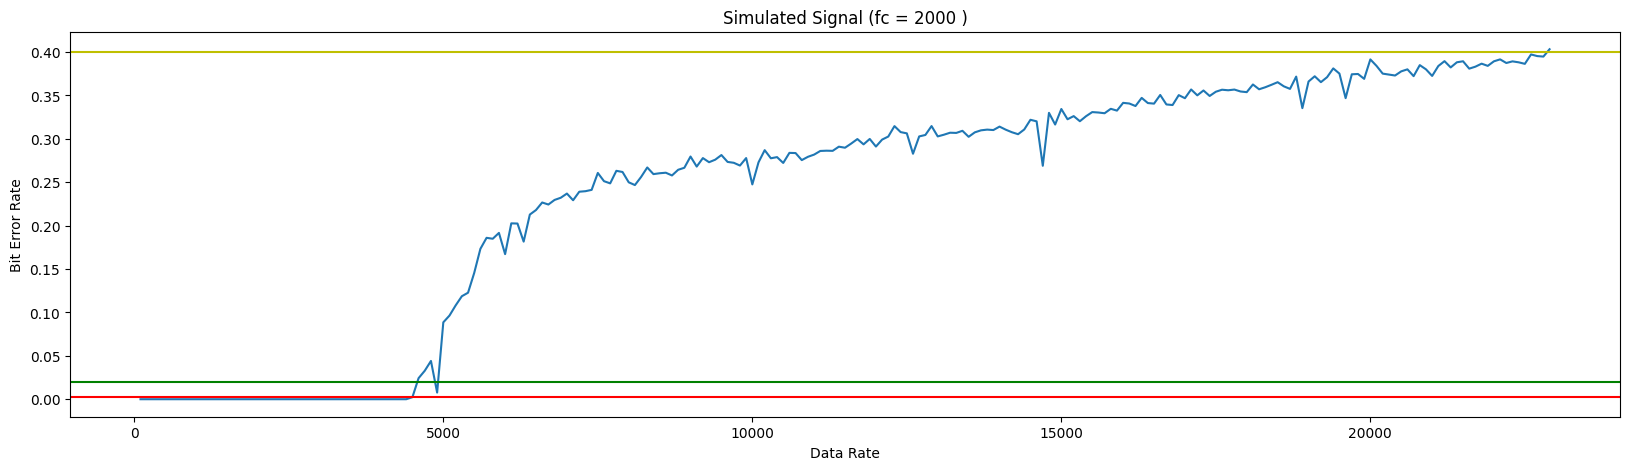

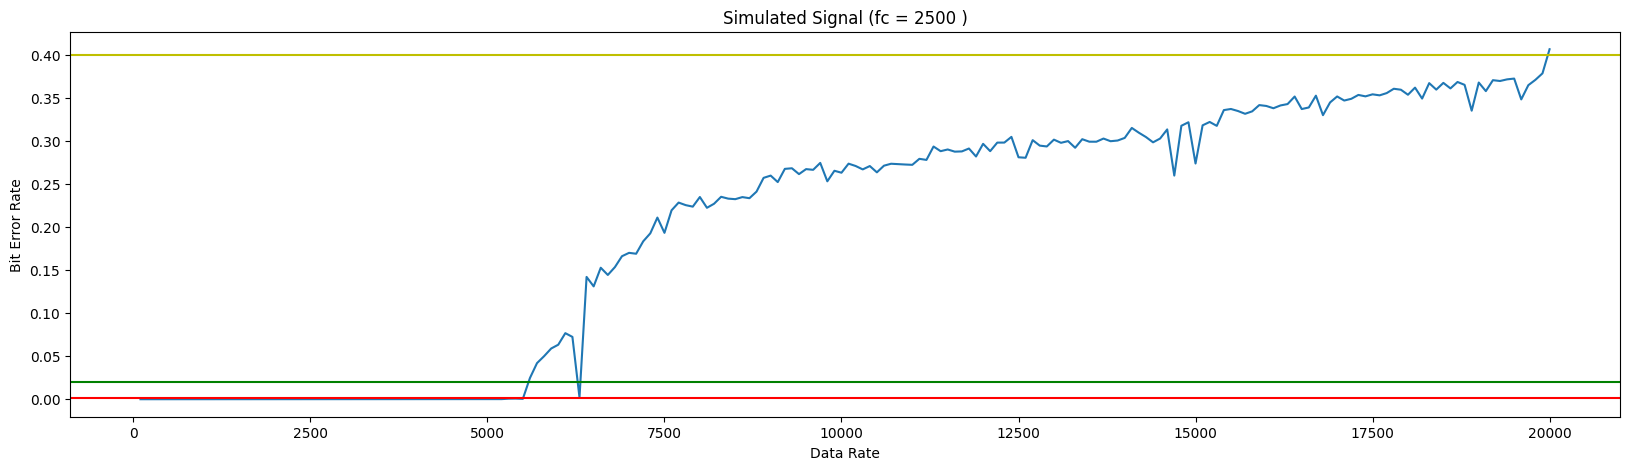

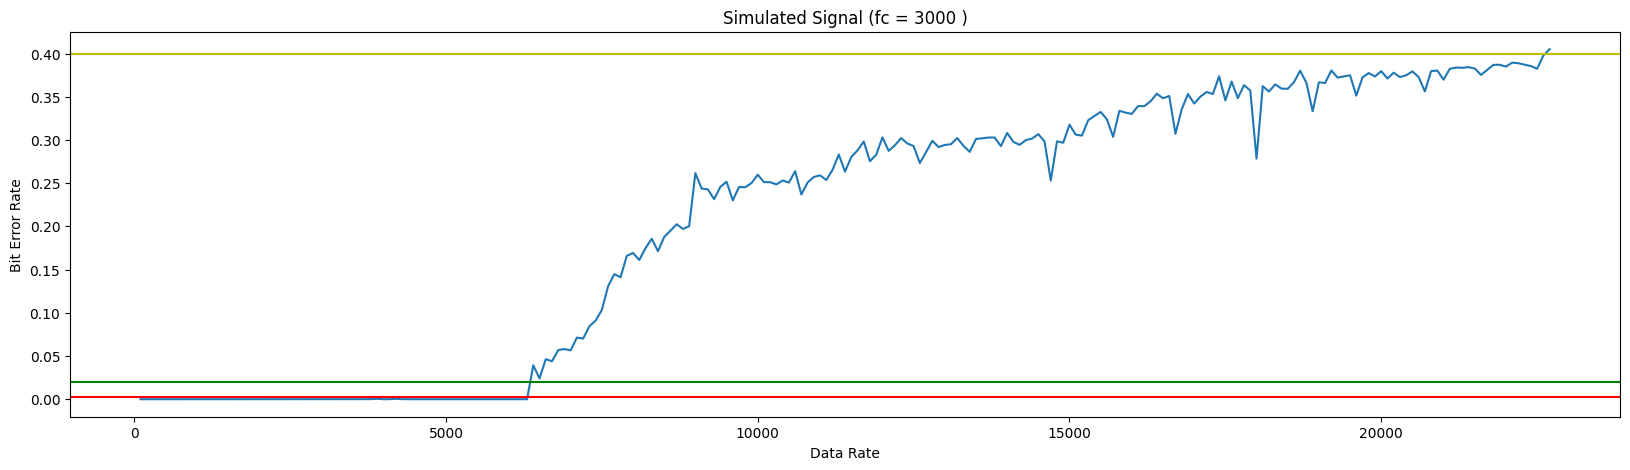

In [43]:
# Generate plots for data rate versus error rate of a signal with no noise
def plot_no_noise(fc):
    rate = 100
    ber = 0
    data_rates = []
    error_rates = [] 
    while ber < 0.4: 
        ber = simulated_no_noise(rate, fc, print_bool=False)
        data_rates.append(rate)
        error_rates.append(ber)
        rate += 100
    plt.plot(data_rates, error_rates)
    plt.title("Simulated Signal (fc = " + str(fc) + " )")
    plt.xlabel("Data Rate")
    plt.ylabel("Bit Error Rate")
    plt.axhline(y = 0.002, color = 'r', linestyle = '-')
    plt.axhline(y = 0.02, color = 'g', linestyle = '-')
    plt.axhline(y = 0.4, color = 'y', linestyle = '-')
    plt.show()
fcs = [2000, 2500, 3000]
for fc in fcs: 
    plot_no_noise(fc)

#### Discussion:
For the Simulated Channel with no physical noise, the table bellow summarizes the estimated data rates for BER cutoffs of 0.2%, 2% and 40% for each of the carrier frequencies chosen, 2000, 2500, and 3000.

| fc (Hz) | Data Rate w/ BER @ 0.2% | Data Rate w/ BER @ 2% | Data Rate w/ BER @ 40% |
|:---------:|:------------:|:----------:|:-----------:|
| 2000    |        4,800      | 5,000     | 27,000       |
| 2500    | 5,200      | 5,300     | 20,000       |
| 3000    | 6,000     | 6,100     | 27,000       |

### 2. Physical Channel in Quiet Environment

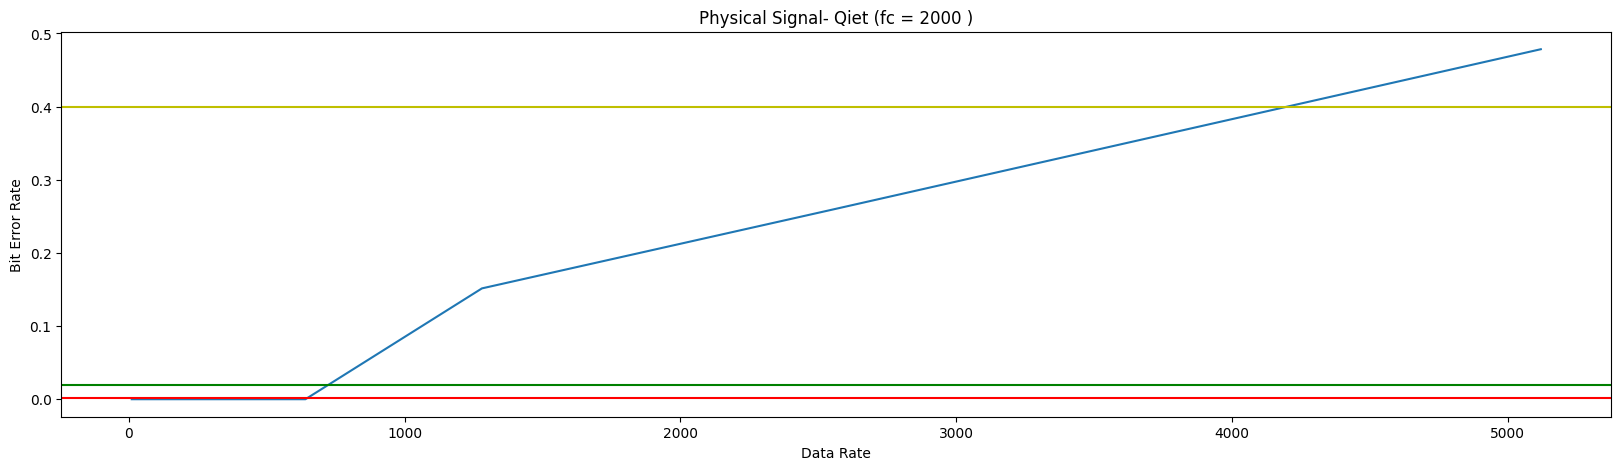

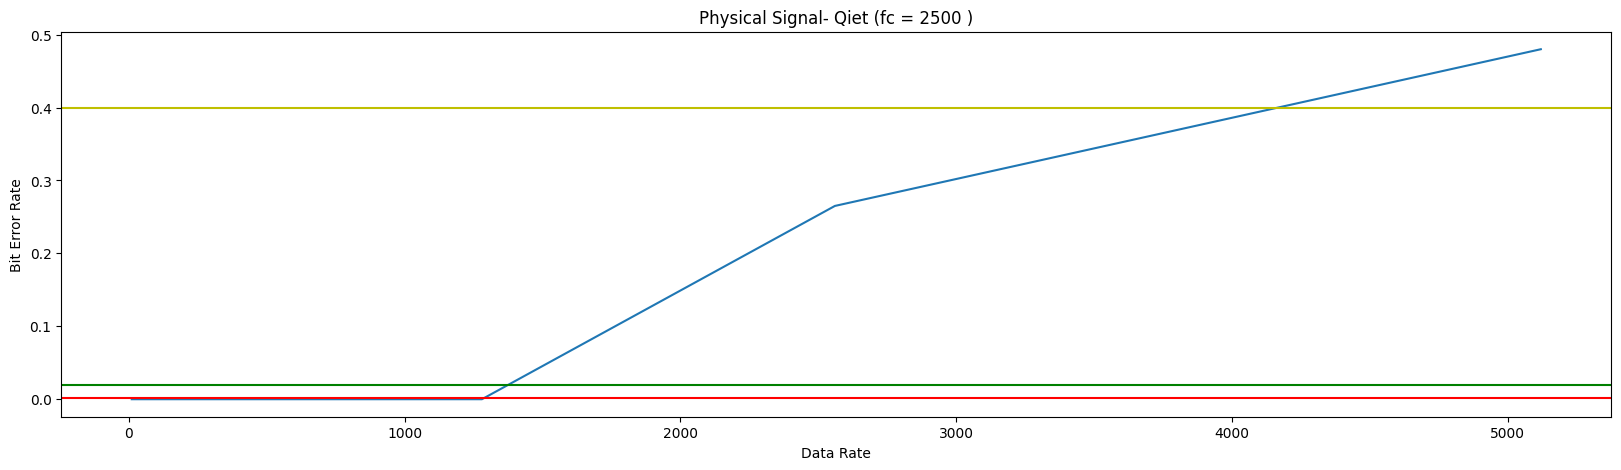

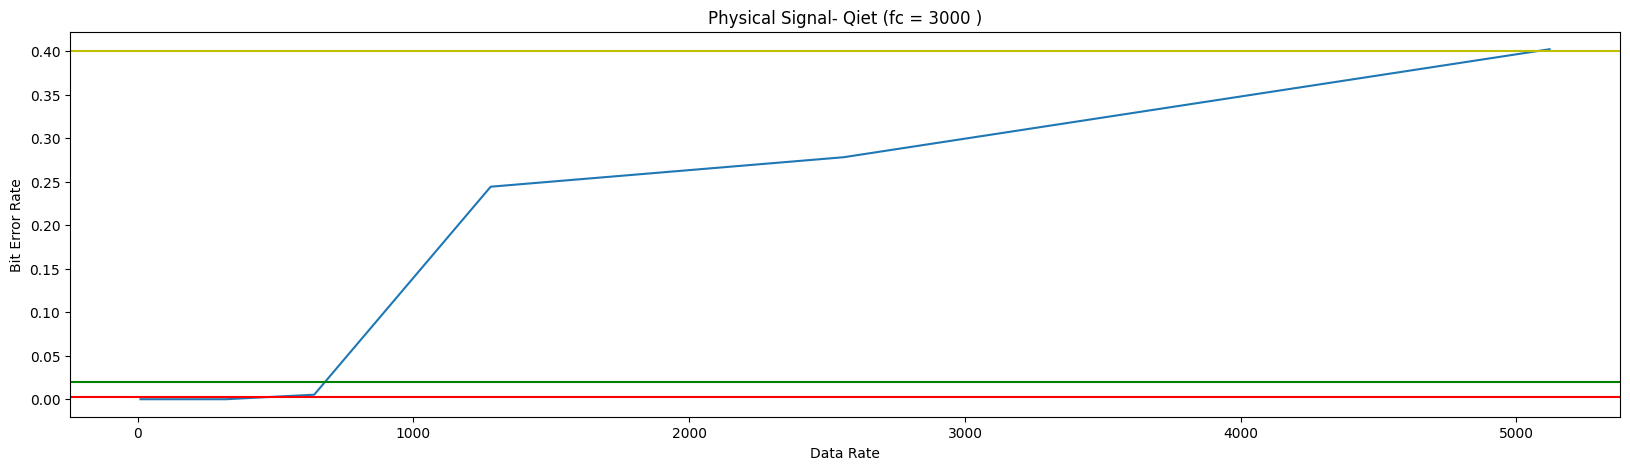

In [46]:
# Generate plots for data rate versus error rate of a quiet physical channel
def plot_phys_quiet(fc):
    rate = 10
    ber = 0
    data_rates = []
    error_rates = [] 
    while ber < 0.4: 
        ber = physical_quiet(rate, fc, print_bool=False)
        data_rates.append(rate)
        error_rates.append(ber)
        rate *= 2
    plt.plot(data_rates, error_rates)
    plt.title("Physical Signal- Qiet (fc = " + str(fc) + " )")
    plt.xlabel("Data Rate")
    plt.ylabel("Bit Error Rate")
    plt.axhline(y = 0.002, color = 'r', linestyle = '-')
    plt.axhline(y = 0.02, color = 'g', linestyle = '-')
    plt.axhline(y = 0.4, color = 'y', linestyle = '-')
    plt.show()
fcs = [2000, 2500, 3000]
for fc in fcs: 
    plot_phys_quiet(fc)

#### Discussion:
For the Physical Channel in a quiet environment, the table bellow summarizes the estimated data rates for BER cutoffs of 0.2%, 2% and 40% for each of the carrier frequencies chosen, 2000, 2500, and 3000.

| fc (Hz) | Data Rate w/ BER @ 0.2% | Data Rate w/ BER @ 2% | Data Rate w/ BER @ 40% |
|:---------:|:------------:|:----------:|:-----------:|
| 2000    |        600      | 650     | 4,200       |
| 2500    | 1,300            | 1,350     | 4,200      |
| 3000    | 600         | 650     | 5,000       |

### 3. Physical Channel with Noise (Clapping)

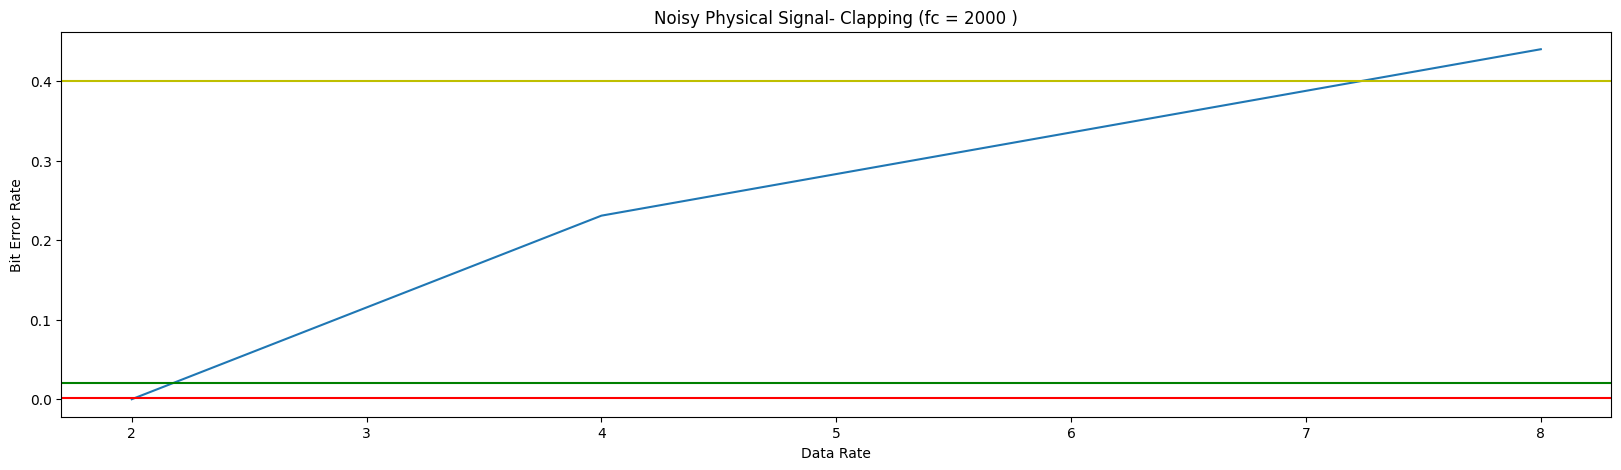

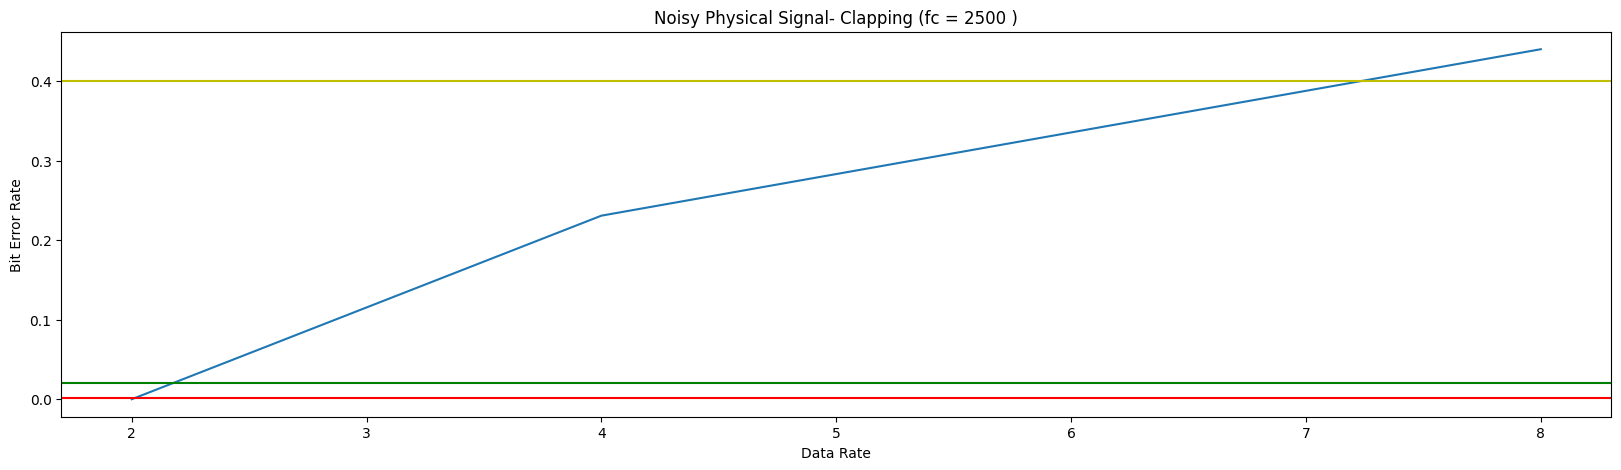

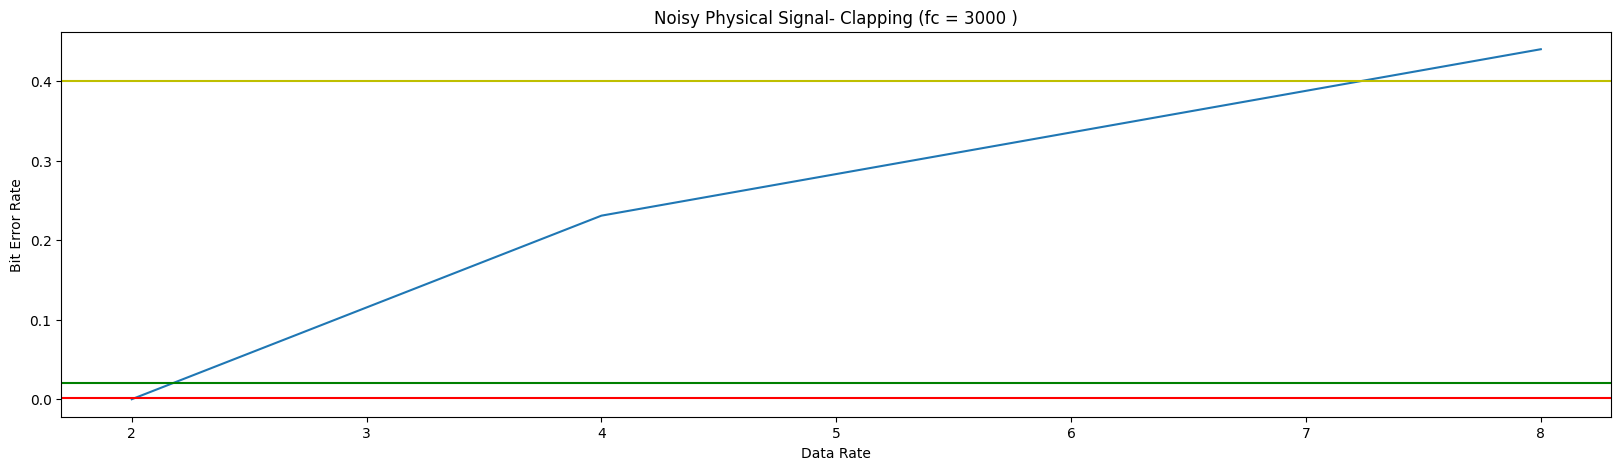

In [47]:
# Generate plots for data rate versus error rate of a noisy physical channel
def plot_phys_noisy(fc):
    rate = 2
    ber = 0
    data_rates = []
    error_rates = [] 
    while ber < 0.4: 
        ber = physical_noisy(rate, fc, clapping, print_bool=False)
        data_rates.append(rate)
        error_rates.append(ber)
        rate *= 2
    plt.plot(data_rates, error_rates)
    plt.title("Noisy Physical Signal- Clapping (fc = " + str(fc) + " )")
    plt.xlabel("Data Rate")
    plt.ylabel("Bit Error Rate")
    plt.axhline(y = 0.002, color = 'r', linestyle = '-')
    plt.axhline(y = 0.02, color = 'g', linestyle = '-')
    plt.axhline(y = 0.4, color = 'y', linestyle = '-')
    plt.show()
fcs = [2000, 2500, 3000]
for fc in fcs: 
    plot_phys_noisy(fc)

#### Discussion:
For the Physical Channel in a noisy environment with clapping, the table bellow summarizes the estimated data rates for BER cutoffs of 0.2%, 2% and 40% for each of the carrier frequencies chosen, 2000, 2500, and 3000.

| fc (Hz) | Data Rate w/ BER @ 0.2% | Data Rate w/ BER @ 2% | Data Rate w/ BER @ 40% |
|:---------:|:------------:|:----------:|:-----------:|
| 2000    |        2      | 2     | 7       |
| 2500    | 2            | 2     | 7      |
| 3000    | 2         | 2     | 7       |

### 4. Physical Channel with Noise (Speaking)

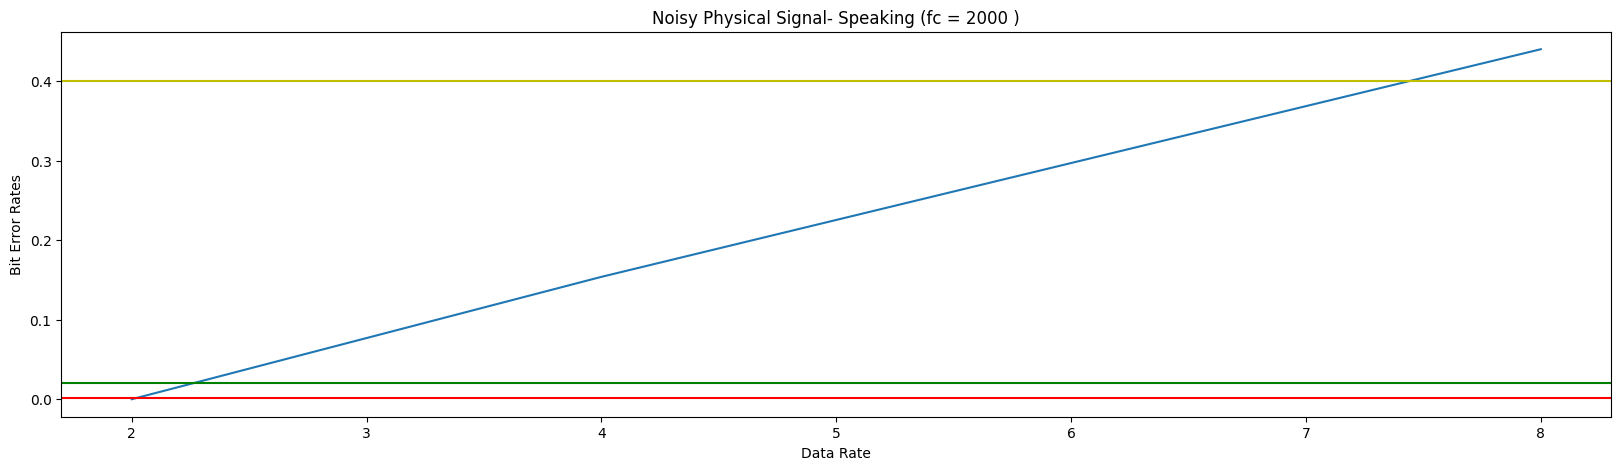

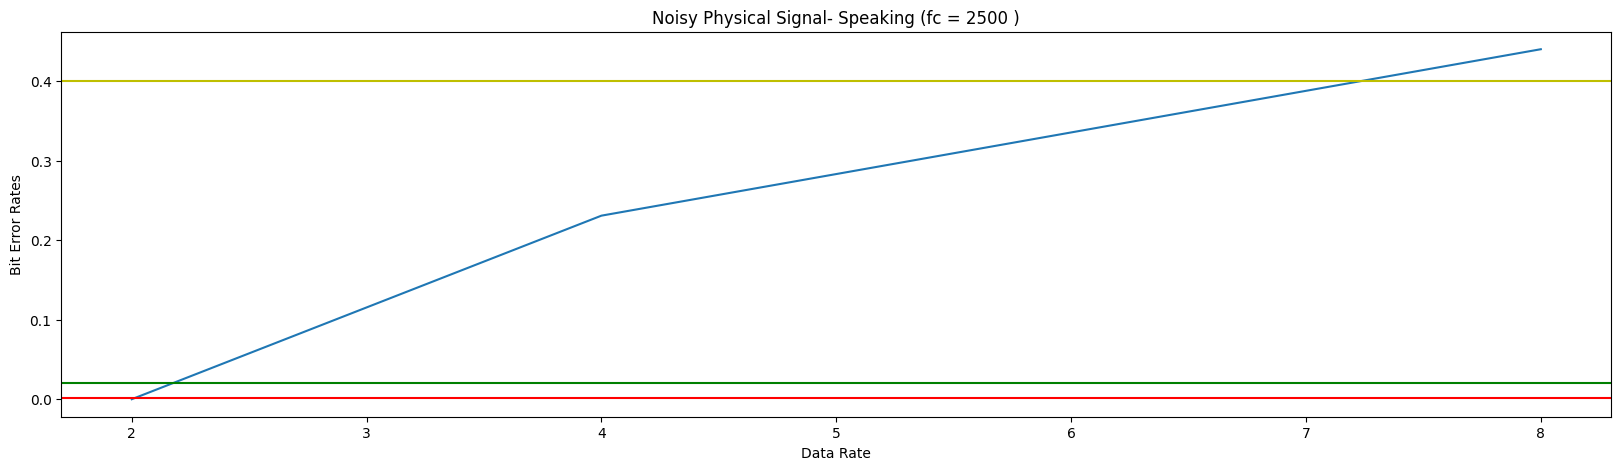

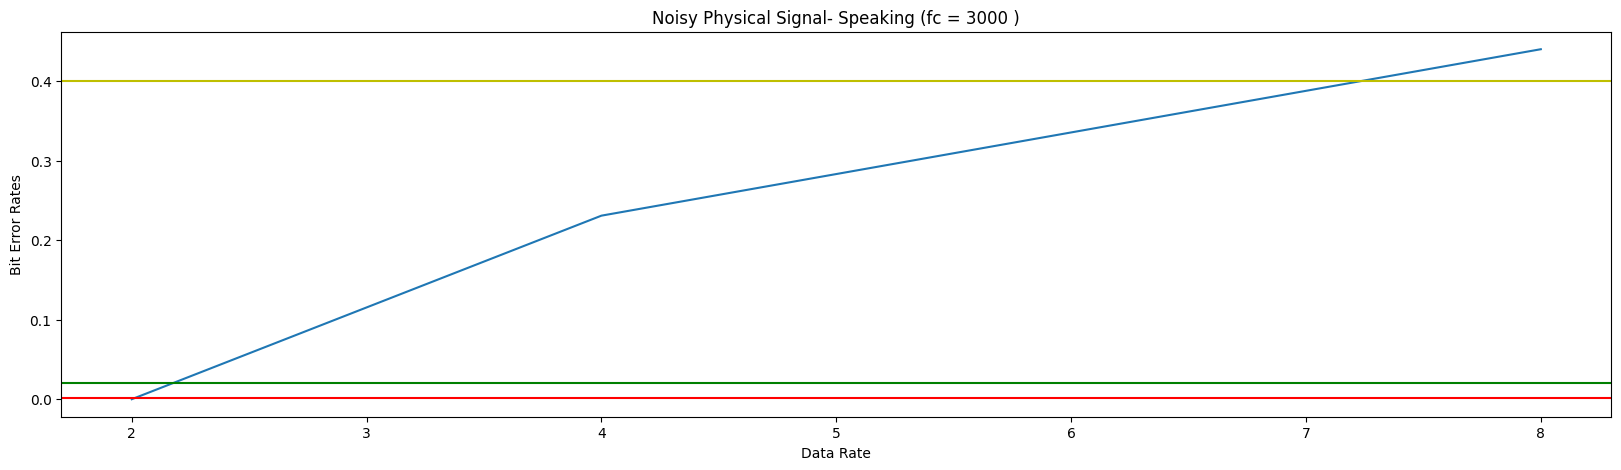

In [50]:
# Generate plots for data rate versus error rate of a noisy physical channel with noise of speaking added
def plot_phys_noisy(fc):
    rate = 2
    ber = 0
    data_rates = []
    error_rates = [] 
    while ber < 0.4: 
        ber = physical_noisy(rate, fc, speaking, print_bool=False)
        data_rates.append(rate)
        error_rates.append(ber)
        rate *= 2
    plt.plot(data_rates, error_rates)
    plt.title("Noisy Physical Signal- Speaking (fc = " + str(fc) + " )")
    plt.xlabel("Data Rate")
    plt.ylabel("Bit Error Rates")
    plt.axhline(y = 0.002, color = 'r', linestyle = '-')
    plt.axhline(y = 0.02, color = 'g', linestyle = '-')
    plt.axhline(y = 0.4, color = 'y', linestyle = '-')
    plt.show()
fcs = [2000, 2500, 3000]
for fc in fcs: 
    plot_phys_noisy(fc)

#### Discussion:
For the Physical Channel in a noisy environment with speaking, the table bellow summarizes the estimated data rates for BER cutoffs of 0.2%, 2% and 40% for each of the carrier frequencies chosen, 2000, 2500, and 3000.

| fc (Hz) | Data Rate w/ BER @ 0.2% | Data Rate w/ BER @ 2% | Data Rate w/ BER @ 40% |
|:---------:|:------------:|:----------:|:-----------:|
| 2000    |        2      | 2     | 7       |
| 2500    | 2            | 2     | 7      |
| 3000    | 2         | 2     | 7       |

### 5. Physical Channel with Noise (Clapping) and Filtering

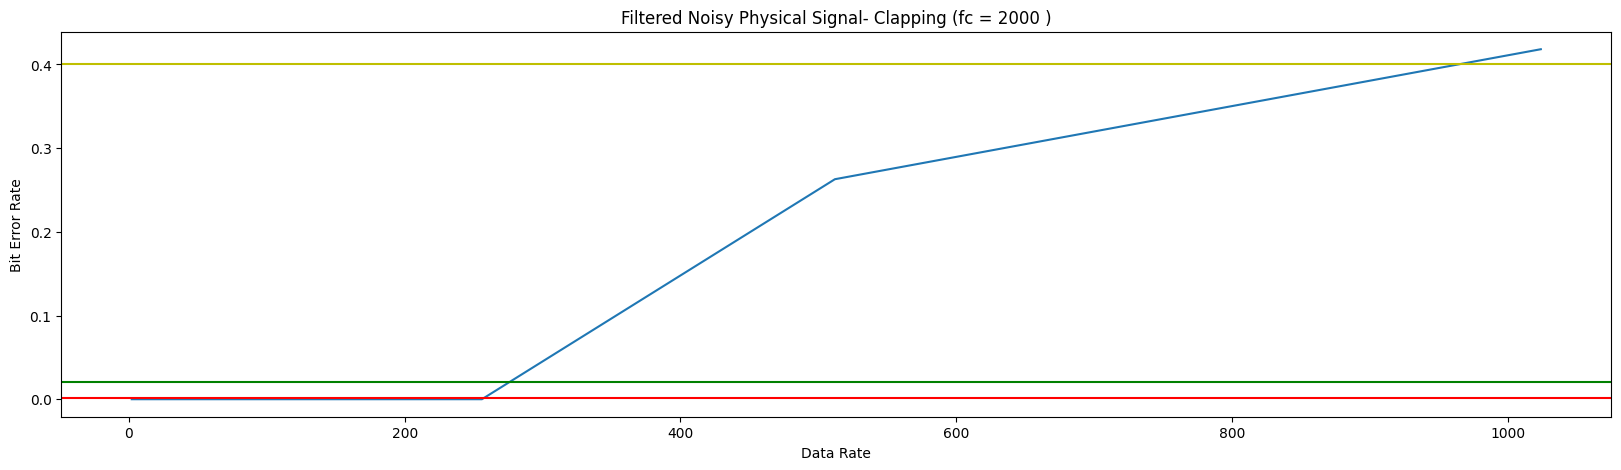

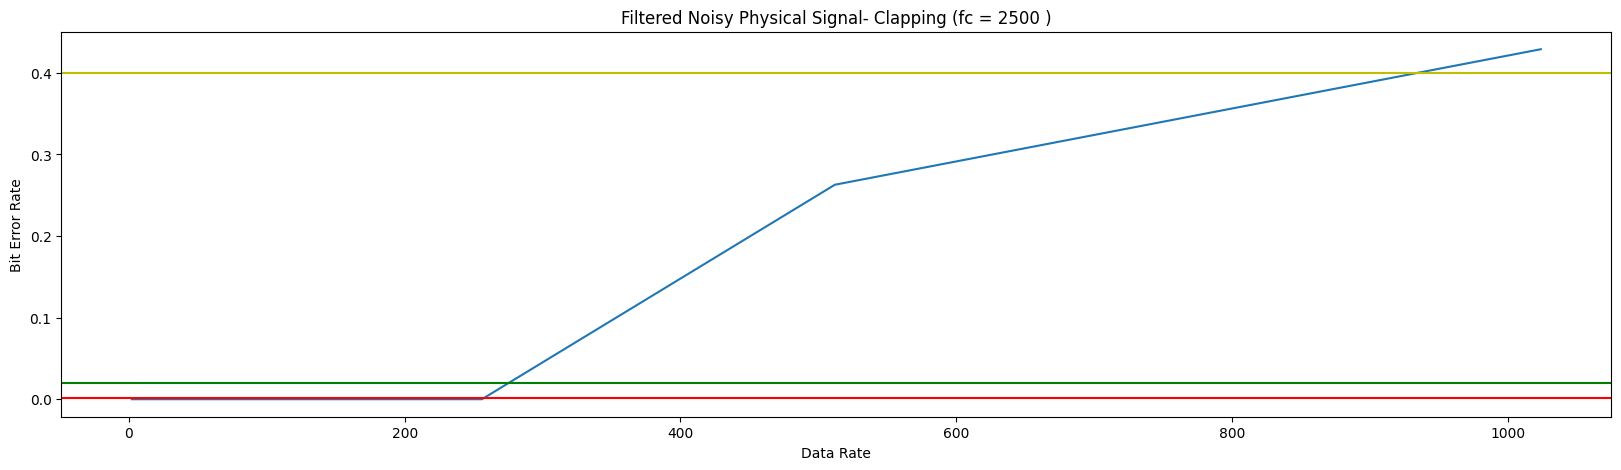

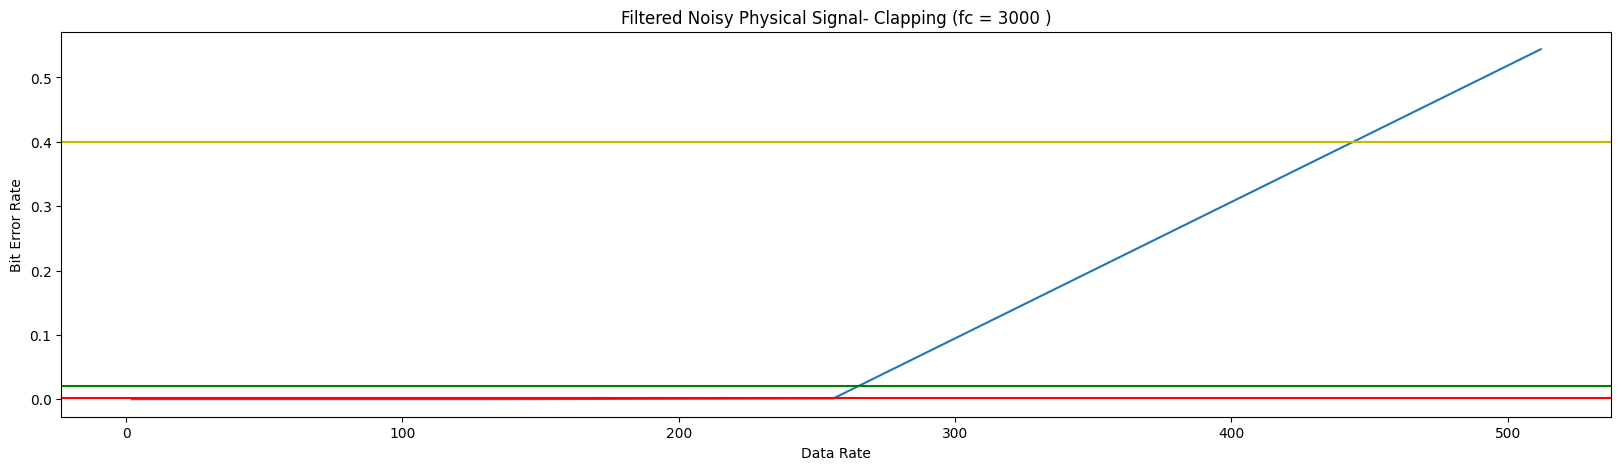

In [53]:
# Generate plots for data rate versus error rate of a filtered noisy physical channel with clapping added
def plot_filtered(fc):
    rate = 2
    ber = 0
    data_rates = []
    error_rates = [] 
    while ber < 0.4: 
        ber = filtered_noisy(rate, fc, clapping, print_bool=False)
        data_rates.append(rate)
        error_rates.append(ber)
        rate *= 2
    plt.plot(data_rates, error_rates)
    plt.title("Filtered Noisy Physical Signal- Clapping (fc = " + str(fc) + " )")
    plt.xlabel("Data Rate")
    plt.ylabel("Bit Error Rate")
    plt.axhline(y = 0.002, color = 'r', linestyle = '-')
    plt.axhline(y = 0.02, color = 'g', linestyle = '-')
    plt.axhline(y = 0.4, color = 'y', linestyle = '-')
    plt.show()
fcs = [2000, 2500, 3000]
for fc in fcs: 
    plot_filtered(fc)

#### Discussion:
For the Filtered Physical Channel in a noisy environment with clapping, the table bellow summarizes the estimated data rates for BER cutoffs of 0.2%, 2% and 40% for each of the carrier frequencies chosen, 2000, 2500, and 3000.

| fc (Hz) | Data Rate w/ BER @ 0.2% | Data Rate w/ BER @ 2% | Data Rate w/ BER @ 40% |
|:---------:|:------------:|:----------:|:-----------:|
| 2000    |        230      | 240     | 950       |
| 2500    | 230            | 240     | 930      |
| 3000    | 250        | 260     | 440       |

### 6. Physical Channel with Noise (Clapping), Filtering, and Error Correction

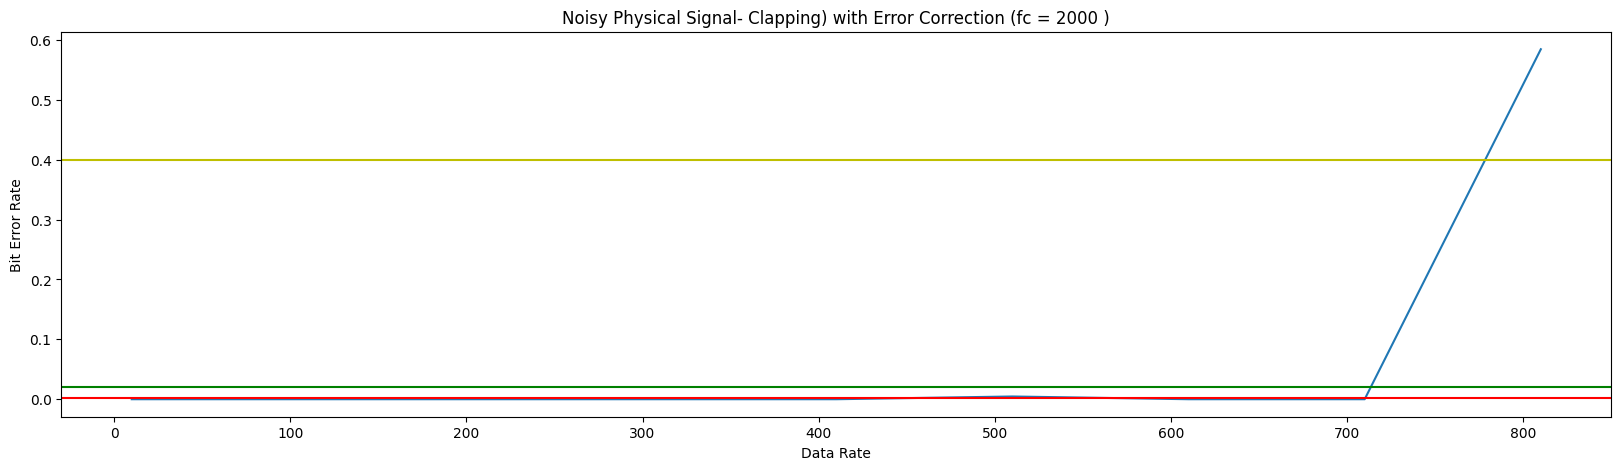

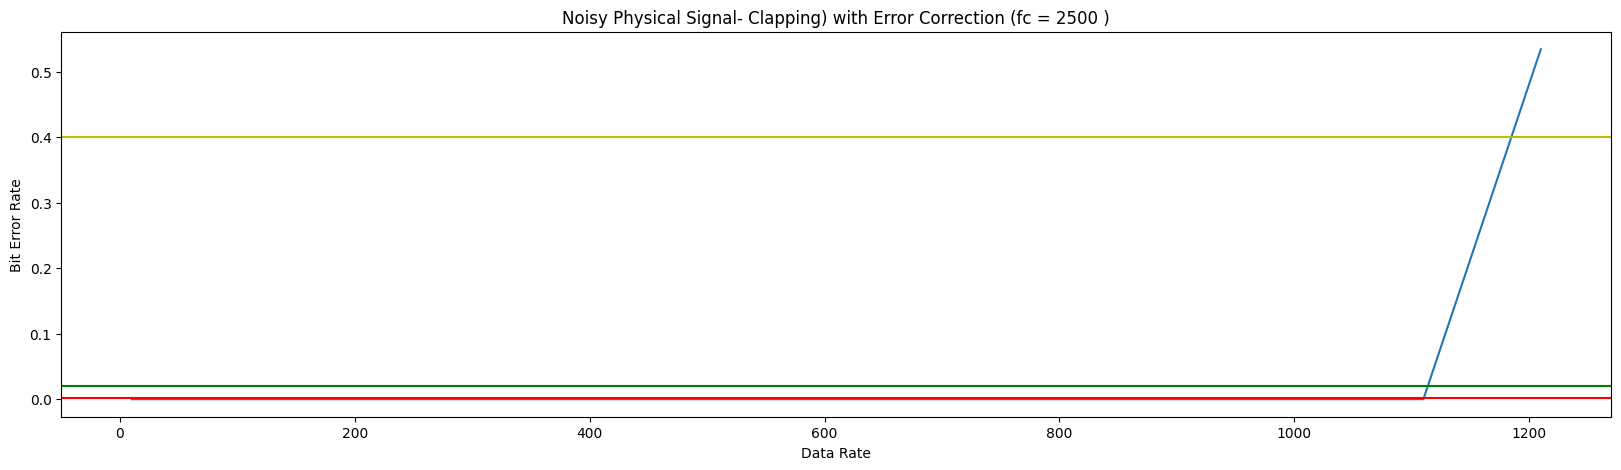

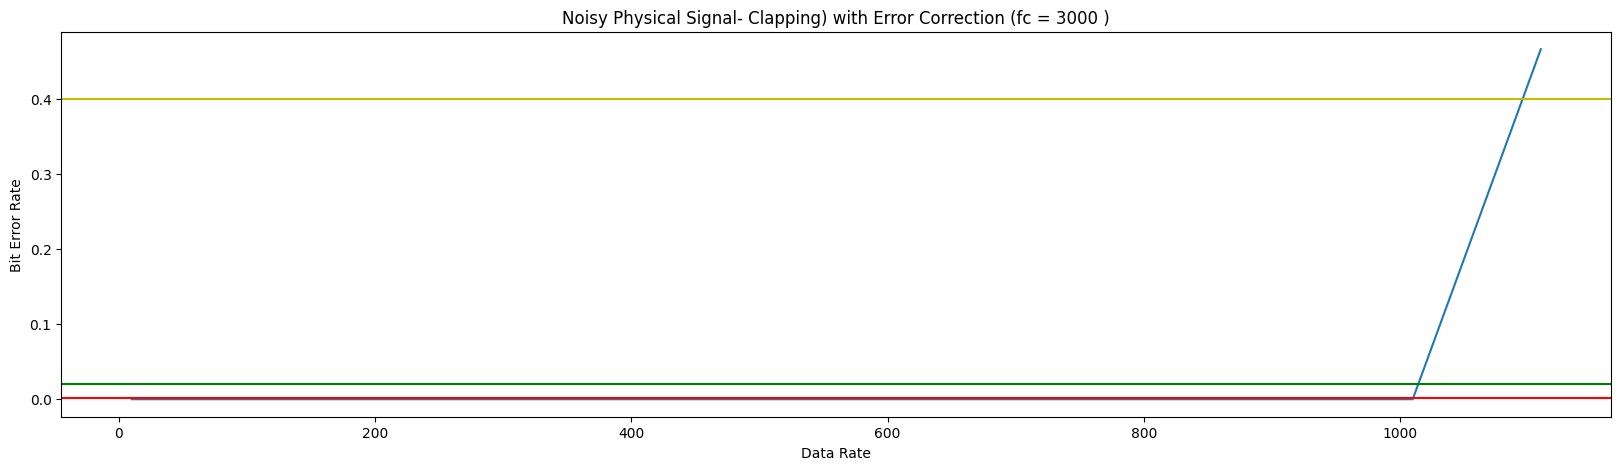

In [56]:
def plot_error_correcting(fc):
    rate = 10
    ber = 0
    data_rates = []
    error_rates = [] 
    while ber < 0.4: 
        ber = physical_error_correction(rate, fc, clapping, print_bool=False)
        data_rates.append(rate)
        error_rates.append(ber)
        rate += 100
    plt.plot(data_rates, error_rates)
    plt.title("Noisy Physical Signal- Clapping) with Error Correction (fc = " + str(fc) + " )")
    plt.xlabel("Data Rate")
    plt.ylabel("Bit Error Rate")
    plt.axhline(y = 0.002, color = 'r', linestyle = '-')
    plt.axhline(y = 0.02, color = 'g', linestyle = '-')
    plt.axhline(y = 0.4, color = 'y', linestyle = '-')
    plt.show()
fcs = [2000, 2500, 3000]
for fc in fcs: 
    plot_error_correcting(fc)


#### Discussion:
For the Filtered, Error Corrected Physical Channel in a noisy environment with clapping, the table bellow summarizes the estimated data rates for BER cutoffs of 0.2%, 2% and 40% for each of the carrier frequencies chosen, 2000, 2500, and 3000.

| fc (Hz) | Data Rate w/ BER @ 0.2% | Data Rate w/ BER @ 2% | Data Rate w/ BER @ 40% |
|:---------:|:------------:|:----------:|:-----------:|
| 2000    |        710      | 720     | 770       |
| 2500    | 1100            | 1110     | 1180      |
| 3000    | 1010        | 1020     | 1100       |


# Part 3: Conclusions and Analysis

To analyze systematic error across different settings, I began by first implementing different functions to report the bit error rate taking rate and  as parameters that can be changed. To test these functions, I ran them with fc = 3000 and reasonable rates as determined in projects 2a-2c. I observed that the error rate was 0 for the simulated channel and physical channel in a quiet environment. The error rate increased when noise of clapping and speaking to around 0.4, and then with filtering, the error rate went back to 0 and stayed at 0 when error correction was added as well. 

One challenge that I faced in the first part of this assignment was finding a way to add noise to my received signal. In order to ensure that the noise was consistent across all of experiments in the next step, I recorded the noise of both clapping and speaking once in the beginning of the project and artifically added them to the signal to allow my results to be more consistent and comparable. I also plotted out the recording for both the clapping and the speaking to be able to visualize that clapping is more noisy and disruptive than speaking. Because of this finding, I used clapping for the filtered and error corrected plots later in the project.

In the second part, I created 6 different plotting functions that internally called the functions from the previous part. The plotting functions started with appropriate data rates and either doubled them or increased by 100, whichever was more appropriate to get to the end data rate in a timely manner. As the rate was increasing, I populated two lists, one with the data rate and one with the BER for the corresponding index. This allowed me to easily plot the data rate against the BER. Finally, I added colored lines corresponding to BER of 0.2%, 2% and 40% to make comparison easier. Furthermore, I chose to use a BER of 40% rather than a BER of 50% because I found that since the message is randomly generated, we are not guaranteed to have exactly 50% 0s and 50% 1s, meaning that in some instances, exponentially increasing the data rate did not cause the BER to ever hit or exceed 50%. This caused an infinite loop and was very unpleasant to listen to, so to avoid this challenge, I calculated the associated data rate for a BER of 40% to prevent infinite looping. 